## Import TensorFlow and other libraries

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf

import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
import tkinter
from tkinter import filedialog
tkinter.Tk().withdraw()
path=filedialog.askdirectory(title='path for whole dataset')
#date="Oct15_Same"
date="Sep21_Same_Dataset_Balanced"
mask="Dataset1_Sep21"
csv_path=3
from glob import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

#tf_device='/gpu:0'
path_gen="../"+date+"/Generator"
path_dis="../"+date+"/Discriminator"

2024-09-21 16:48:39.732957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.config.list_physical_devices('GPU')

2024-09-21 16:48:55.781340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-09-21 16:48:55.808151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-09-21 16:48:55.808177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-21 16:48:55.810757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-21 16:48:55.810794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-09-21 16:48:55.812571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 50 #350
IMAGE_SIZE=256

#Image_number=4050

In [5]:
def load_data(path, split=0.05):
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    print(len(images))
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
path

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After'

In [7]:
# Helper function to extract filenames
def get_filenames(paths):
    return [os.path.basename(path) for path in paths]

# Modified load functions
def load_train_with_filename(path, label, filename):
    image, real_image = load_train(path, label)
    return image, real_image, filename

def load_test_with_filename(path, label, filename):
    image, real_image = load_test(path, label)
    return image, real_image, filename

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_data(path)

20936


In [9]:
train_x

['/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Images/010255.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Images/005690.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Images/000875.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Images/016201.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Images/013435.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Images/015679.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Image

In [10]:
len(train_y)

18844

In [11]:
def load_train(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    
    input_image = tf.image.decode_png(image1)
   
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
        #input_image,real_image=augment(input_image,real_image)
        real_image = (real_image / 127.5) - 1
        input_image = (input_image / 127.5) - 1
        return input_image, real_image
    else:
        input_image = (input_image / 127.5) - 1
        return input_image

In [12]:
def load_test(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [13]:
def load_valid(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    if(input_image.shape!=([256,256,3])):
        print(input_image.shape)
        print(256-input_image.shape[0])
        print(256-input_image.shape[1])
        input_image=tf.image.pad_to_bounding_box(input_image,0,0,256,256)
    #input_image=tf.image.resize(input_image, [256, 256],
     #                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        #real_image=tf.image.resize(real_image, [256, 256],
                       #   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

 
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [14]:
len(test_y)

1046

In [15]:
import random

def augment(input_image, real_image):
    seed = (1, 2)
    tf.random.set_seed(1234)

    if tf.random.uniform(()) > 0.5:
        # Random brightness
        

        # Random saturation
        input_image = tf.image.stateless_random_saturation(input_image, lower=0, upper=1.5, seed=seed)
        real_image = tf.image.stateless_random_saturation(real_image, lower=0, upper=1.5, seed=seed)

        # Random contrast
        input_image = tf.image.stateless_random_contrast(input_image, lower=0, upper=1.5, seed=seed)
        real_image = tf.image.stateless_random_contrast(real_image, lower=0, upper=1.5, seed=seed)

        input_image = tf.image.adjust_gamma(input_image, gamma= random.uniform(0.5, 2.0))
        real_image = tf.image.adjust_gamma(real_image, gamma= random.uniform(0.5, 2.0))

    
        input_image = tf.clip_by_value(input_image, 0, 255)
        real_image = tf.clip_by_value(real_image, 0, 255)


    return input_image, real_image

In [16]:
import random

def augment(input_image, real_image):
    # Set a seed for reproducibility
    seed = (1, 2)
    tf.random.set_seed(1234)
    
    # Apply random rotation by 90 degrees
    if tf.random.uniform(()) > 0.5:
        num_rotations = random.choice([1, 2, 3])  # Randomly choose 90, 180, or 270 degrees rotation
        input_image = tf.image.rot90(input_image, k=num_rotations)
        real_image = tf.image.rot90(real_image, k=num_rotations)
    
    return input_image, real_image


In [17]:
# Train dataset
train_filenames = get_filenames(train_x)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y, train_filenames))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_train_with_filename)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Validation dataset
valid_filenames = get_filenames(valid_x)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y, valid_filenames))
valid_dataset = valid_dataset.map(load_test_with_filename)
valid_dataset = valid_dataset.batch(1)

# Test dataset
test_filenames = get_filenames(test_x)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y, test_filenames))
test_dataset = test_dataset.map(load_test_with_filename)
test_dataset = test_dataset.batch(1)

2024-09-21 16:49:04.182437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 16:49:04.203234: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699610000 Hz
2024-09-21 16:49:04.204207: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c61f6ba6d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-09-21 16:49:04.204232: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-09-21 16:49:04.263789: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c61f72e440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-2

In [18]:
inp,re=load_train(train_x[10],train_y[10])

2024-09-21 16:49:05.414255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 001903.png
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 013946.png
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 017916.png
tf.Tensor(-0.49019605, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-0.49019605, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 018653.png
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 011520.png


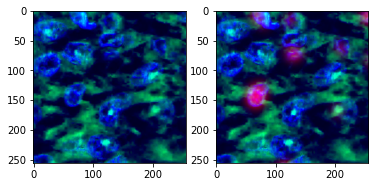

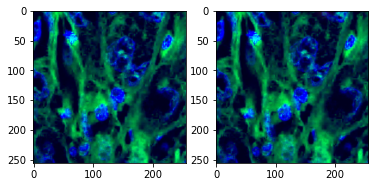

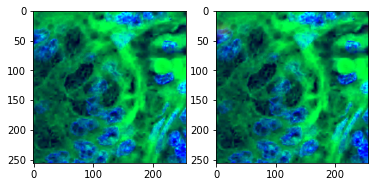

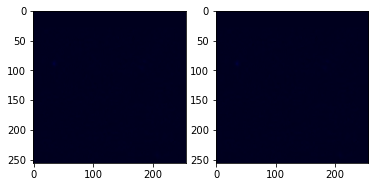

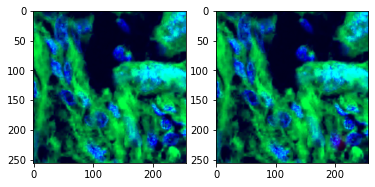

In [19]:
for x, y, filename in train_dataset.take(1):
    # print(x.shape[0])
    for i in range(5):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x[i]*0.5+0.5)
        print(tf.reduce_max(x[i]))
        print(tf.reduce_min(x[i]))
        plt.subplot(1,2,2)
        plt.imshow(y[i]*0.5+0.5)
        print(tf.reduce_max(y[i]))
        print(tf.reduce_min(y[i]))
        print("Filename:", filename[i].numpy().decode('utf-8'))

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2024-09-21 16:49:15.493737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


(1, 128, 128, 3)


2024-09-21 16:49:16.526455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [25]:
# CBAM Module
def cbam_block(feature_map, reduction_ratio=16):
    """
    Convolutional Block Attention Module.
    """
    # Channel Attention
    channel_avg_pool = tf.reduce_mean(feature_map, axis=[1, 2], keepdims=True)
    channel_max_pool = tf.reduce_max(feature_map, axis=[1, 2], keepdims=True)
    channel_concat = tf.concat([channel_avg_pool, channel_max_pool], axis=-1)
    channel_dense = tf.keras.layers.Dense(feature_map.shape[-1] // reduction_ratio, activation='relu')(channel_concat)
    channel_dense = tf.keras.layers.Dense(feature_map.shape[-1], activation='sigmoid')(channel_dense)
    channel_refined = feature_map * channel_dense

    # Spatial Attention
    spatial_avg_pool = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)
    spatial_max_pool = tf.reduce_max(channel_refined, axis=-1, keepdims=True)
    spatial_concat = tf.concat([spatial_avg_pool, spatial_max_pool], axis=-1)
    spatial_conv = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_concat)
    spatial_refined = channel_refined * spatial_conv

    return spatial_refined

# Convolutional Block
def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same', use_bn=True):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    if use_bn:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    return x

# Nested U-Net++ Generator with CBAM
def unetpp_generator(input_shape=(256, 256, 3), num_filters=64, num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv0_0 = conv_block(inputs, num_filters)
    conv0_0 = conv_block(conv0_0, num_filters)
    pool0 = tf.keras.layers.MaxPooling2D((2, 2))(conv0_0)

    conv1_0 = conv_block(pool0, num_filters * 2)
    conv1_0 = conv_block(conv1_0, num_filters * 2)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1_0)

    conv2_0 = conv_block(pool1, num_filters * 4)
    conv2_0 = conv_block(conv2_0, num_filters * 4)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2_0)

    conv3_0 = conv_block(pool2, num_filters * 8)
    conv3_0 = conv_block(conv3_0, num_filters * 8)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3_0)

    conv4_0 = conv_block(pool3, num_filters * 16)
    conv4_0 = conv_block(conv4_0, num_filters * 16)

    # Decoder with Nested Skip Connections
    up3_1 = tf.keras.layers.UpSampling2D((2, 2))(conv4_0)
    up3_1 = tf.keras.layers.Concatenate()([up3_1, conv3_0])
    up3_1 = conv_block(up3_1, num_filters * 8)
    up3_1 = conv_block(up3_1, num_filters * 8)
    up3_1 = cbam_block(up3_1)  # Apply CBAM

    up2_2 = tf.keras.layers.UpSampling2D((2, 2))(up3_1)
    up2_2 = tf.keras.layers.Concatenate()([up2_2, conv2_0])
    up2_2 = conv_block(up2_2, num_filters * 4)
    up2_2 = conv_block(up2_2, num_filters * 4)
    up2_2 = cbam_block(up2_2)

    up1_3 = tf.keras.layers.UpSampling2D((2, 2))(up2_2)
    up1_3 = tf.keras.layers.Concatenate()([up1_3, conv1_0])
    up1_3 = conv_block(up1_3, num_filters * 2)
    up1_3 = conv_block(up1_3, num_filters * 2)
    up1_3 = cbam_block(up1_3)

    up0_4 = tf.keras.layers.UpSampling2D((2, 2))(up1_3)
    up0_4 = tf.keras.layers.Concatenate()([up0_4, conv0_0])
    up0_4 = conv_block(up0_4, num_filters)
    up0_4 = conv_block(up0_4, num_filters)
    up0_4 = cbam_block(up0_4)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='tanh')(up0_4)

    return tf.keras.Model(inputs=[inputs], outputs=[outputs])

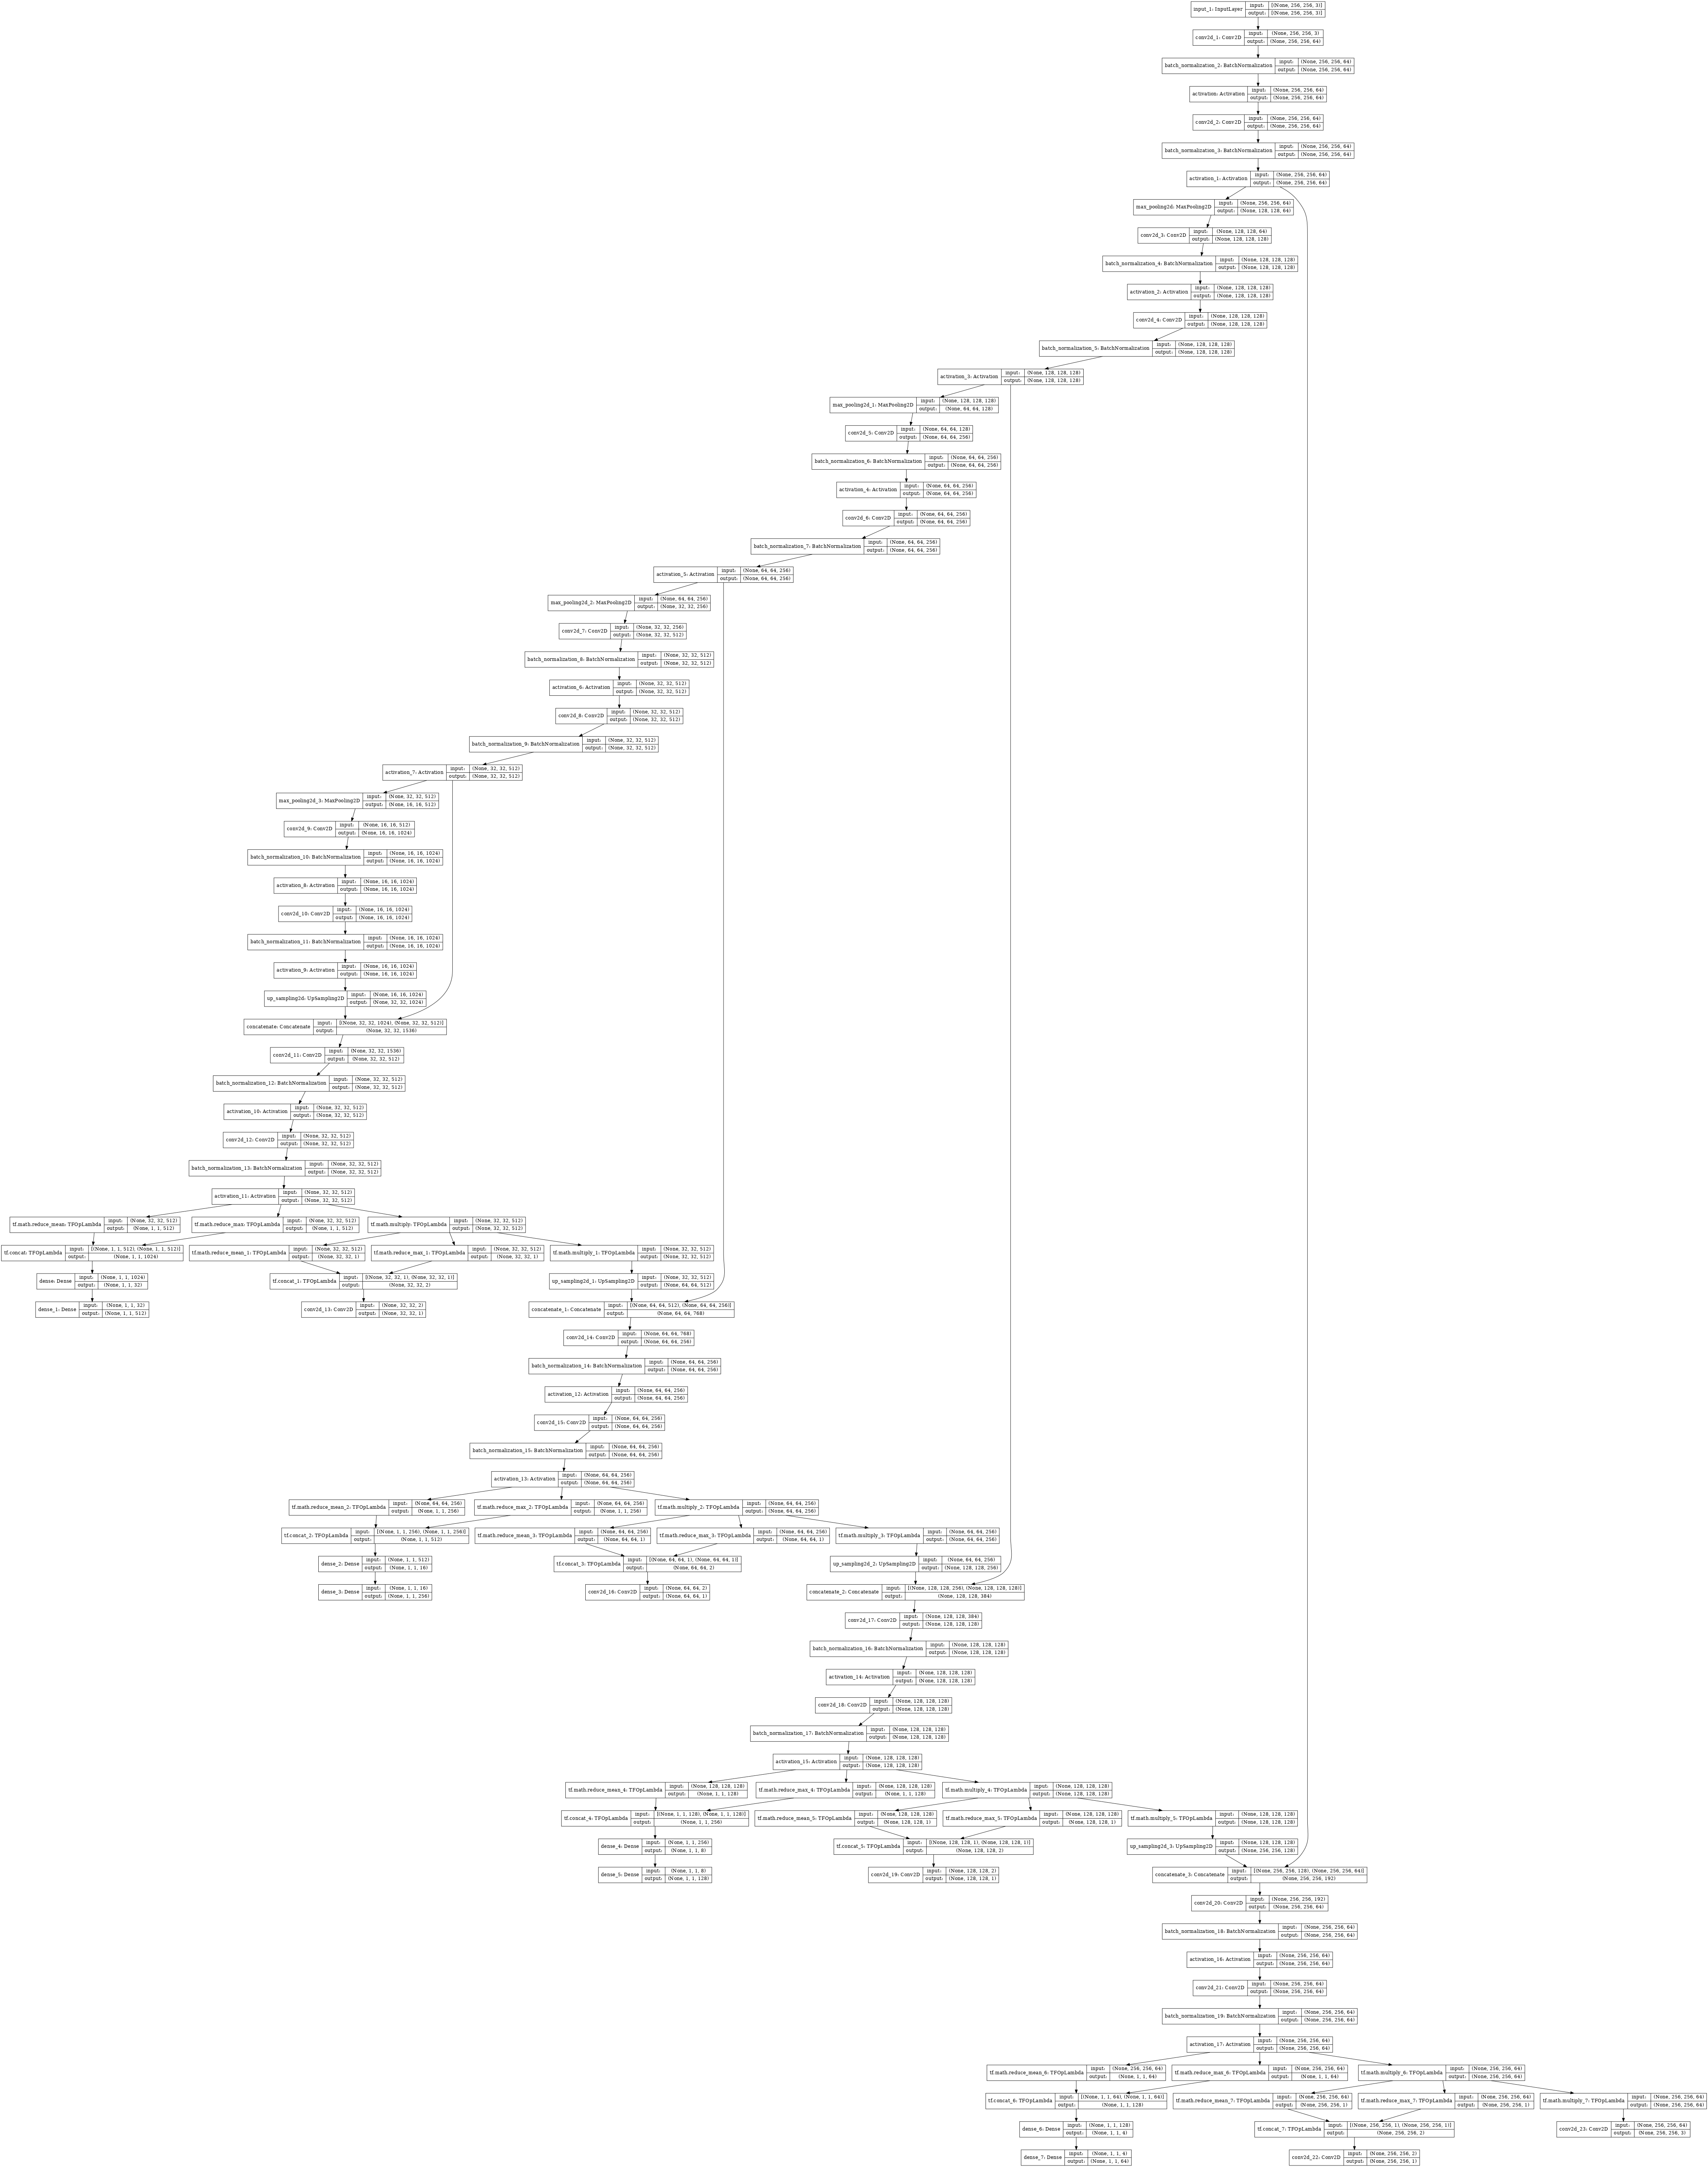

In [26]:
generator = unetpp_generator(input_shape=(256, 256, 3), num_filters=64, num_classes=3)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [27]:
for i, layer in enumerate(generator.layers):
    print(f"{layer.name}, Type: {layer.__class__.__name__}, Output Shape: {layer.output_shape}, Params: {sum(p.size for p in layer.get_weights())}")

input_1, Type: InputLayer, Output Shape: [(None, 256, 256, 3)], Params: 0
conv2d_1, Type: Conv2D, Output Shape: (None, 256, 256, 64), Params: 1792
batch_normalization_2, Type: BatchNormalization, Output Shape: (None, 256, 256, 64), Params: 256
activation, Type: Activation, Output Shape: (None, 256, 256, 64), Params: 0
conv2d_2, Type: Conv2D, Output Shape: (None, 256, 256, 64), Params: 36928
batch_normalization_3, Type: BatchNormalization, Output Shape: (None, 256, 256, 64), Params: 256
activation_1, Type: Activation, Output Shape: (None, 256, 256, 64), Params: 0
max_pooling2d, Type: MaxPooling2D, Output Shape: (None, 128, 128, 64), Params: 0
conv2d_3, Type: Conv2D, Output Shape: (None, 128, 128, 128), Params: 73856
batch_normalization_4, Type: BatchNormalization, Output Shape: (None, 128, 128, 128), Params: 512
activation_2, Type: Activation, Output Shape: (None, 128, 128, 128), Params: 0
conv2d_4, Type: Conv2D, Output Shape: (None, 128, 128, 128), Params: 147584
batch_normalization_5,

In [28]:
import csv

# Assuming 'output.csv' is the desired CSV file
csv_file_path = 'output.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header to the CSV file
    csv_writer.writerow(['Layer Name', 'Layer Type', 'Output Shape', 'Params'])

    # Assuming generator is your model
    for i, layer in enumerate(generator.layers):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape
        params = sum(p.size for p in layer.get_weights())

        # Write the information to the CSV file
        csv_writer.writerow([layer_name, layer_type, output_shape, params])

print(f"Data has been generated and saved to {csv_file_path}.")

Data has been generated and saved to output.csv.


In [29]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")


generator.summary(positions = [1, 6, 2, 23], print_fn=custom_print_fn)

In [30]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")

# Assuming you have a model object
model = generator

# Display model summary using the custom print function
model.summary(print_fn=custom_print_fn)


In [31]:
import re
import csv

# Assuming 'input.txt' contains the text with dotted lines
file_path = 'model_summary.txt'

# Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

# Define a regular expression to capture the content between the dotted lines
pattern = re.compile(r"_+([\w\d\[\]\(\)]+)_+")

# Find all matches in the content
matches = re.findall(pattern, content)

# Write the matches to a CSV file
csv_file_path = 'output.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Layer'])  # Write header

    for match in matches:
        csv_writer.writerow([match])

print(f"Data has been extracted and saved to {csv_file_path}.")


Data has been extracted and saved to output.csv.


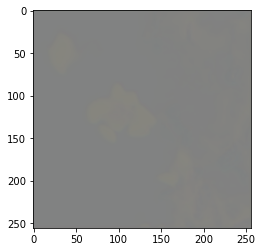

In [32]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]*0.5+0.5)

In [33]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [34]:
def extract_cd3_positive_regions(image, min_red_intensity=-0.9):
    # Assuming 'image' is in the format (height, width, channels) where channels represent RGB

    red_channel = image[:, :, 0]  # Red channel

    # Create a binary mask based on red pixel intensity
    binary_mask = tf.cast(red_channel > min_red_intensity, tf.float32)

    return binary_mask

In [35]:
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + 1e-6)  # Adding a small constant to avoid division by zero

In [36]:
def intersection_over_union(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6) 

In [37]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

In [38]:

def fuzzy_jaccard_loss(y_true, y_pred, tolerance=0.1):
    """
    Calculate the Fuzzy Jaccard Loss for two normalized grayscale images.
    This function is designed to be used as a loss function in TensorFlow models.

    Parameters:
    y_true : Tensor
        Ground truth normalized grayscale image.
    y_pred : Tensor
        Predicted normalized grayscale image.
    tolerance : float
        Maximum difference in intensity values to be considered similar.

    Returns:
    Tensor
        Fuzzy Jaccard Loss (1 - Fuzzy Jaccard Index).
    """
    # Ensure the tensors are of the same shape
    tf.debugging.assert_equal(tf.shape(y_true), tf.shape(y_pred), 
                              message="Inputs must have the same shape")

    # Calculate the similarity matrix
    similarity_matrix = tf.exp(-tf.abs(y_true - y_pred) / tolerance)

    # Calculate the intersection and union
    intersection = tf.reduce_sum(similarity_matrix)
    union = tf.cast(tf.size(y_true), tf.float32)  # Total number of pixels

    # Calculate the Fuzzy Jaccard Index
    fuzzy_jaccard = intersection / union

    # Return the loss (1 - Fuzzy Jaccard Index)
    return 1.0 - fuzzy_jaccard

In [39]:
LAMBDA = 100

In [67]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  gen_mask_1 = extract_cd3_positive_regions(gen_output, min_red_intensity=-0.9)
  target_mask_1 = extract_cd3_positive_regions(target,min_red_intensity=-0.9)
  dice_loss_1 = 1 - dice_coefficient(target_mask_1, gen_mask_1)

  # Dice coefficient loss
  #iou_loss = 1 - intersection_over_union(target_mask, gen_mask)
  #dice_loss = 1 - dice_coefficient(target_mask, gen_mask)

  lambda_dice1 = 600

  iou_loss = lambda_dice1*dice_loss_1

  lambda_focal = 200
  #cd3_loss = focal_loss(target_mask, gen_mask)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  jacard_loss = fuzzy_jaccard_loss(target, gen_output)
  #LAMBDA=dynamic_lambda(target,gen_output)

#  red_mae_loss = tf.reduce_mean(tf.abs((target - gen_output) * target_mask))

  total_gen_loss = gan_loss + LAMBDA*l1_loss + lambda_dice1*dice_loss_1 

  return total_gen_loss, gan_loss, l1_loss, iou_loss

In [68]:
# For the test dataset
for x, y, filename in test_dataset.take(20):
    a = (extract_cd3_positive_regions(image=y[0], min_red_intensity=-0.9))
    b = (extract_cd3_positive_regions(image=x[0], min_red_intensity=-0.9))
    print(250*(1-dice_coefficient(a,b)))
    print("Filename:", filename[0].numpy().decode('utf-8'))

tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 011881.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 013502.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 004364.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 007161.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 000394.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 002143.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 009285.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 004652.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 000988.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 000569.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 019360.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 009008.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 006094.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 014020.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 018213.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 011

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [69]:
def Discriminator():
  size=4
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, size, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, size)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, size)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, size, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, size, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

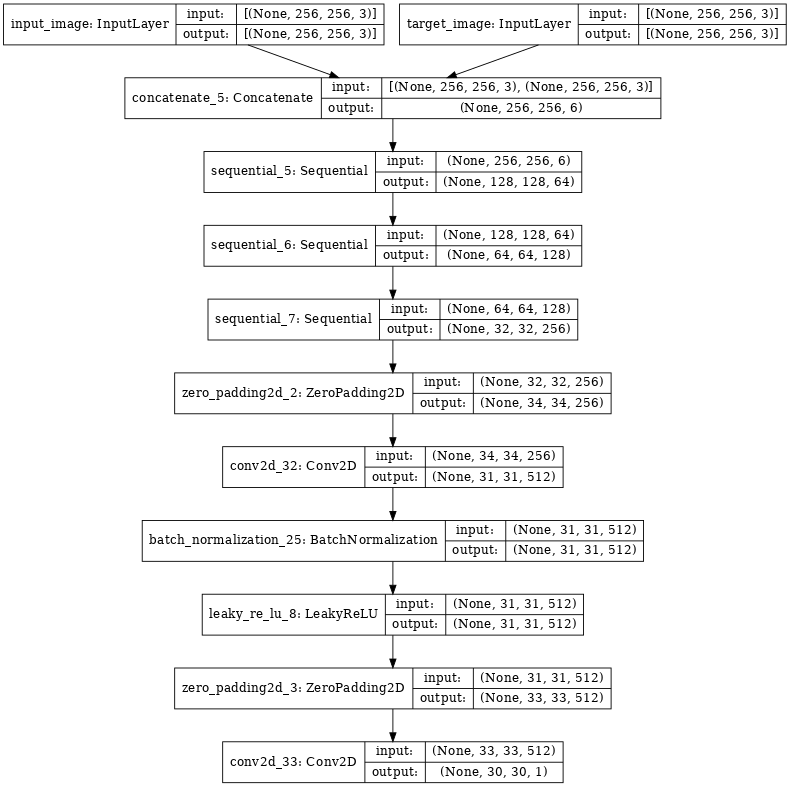

In [70]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [71]:
import csv

# Assuming 'output.csv' is the desired CSV file
csv_file_path = 'output.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header to the CSV file
    csv_writer.writerow(['Layer Name', 'Layer Type', 'Output Shape', 'Params'])

    # Assuming generator is your model
    for i, layer in enumerate(discriminator.layers):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape
        params = sum(p.size for p in layer.get_weights())

        # Write the information to the CSV file
        csv_writer.writerow([layer_name, layer_type, output_shape, params])

print(f"Data has been generated and saved to {csv_file_path}.")

Data has been generated and saved to output.csv.


In [72]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")

# Assuming you have a model object
model = discriminator

# Display model summary using the custom print function
model.summary(print_fn=custom_print_fn)

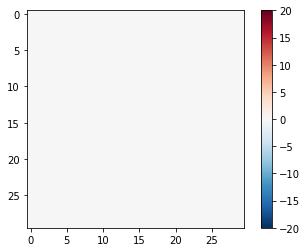

In [73]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [74]:
#1-bce-dice

def loss_object_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    l=loss_object1(y_true,y_pred)
    return tf.abs(-l+(numerator / denominator))

In [75]:
def dynamic_lambda(i1,i2):
  
    a=tf.equal(i1,i2)
    b=tf.cast(a,tf.float32)
    
    L=LAMBDA/(0.1+tf.reduce_mean(b))
    tf.print(L, output_stream=sys.stderr)
    return L

In [76]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    #print(total_disc_loss)
    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [77]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [78]:
checkpoint_dir = './training_checkpoints/'+date+"/"+mask
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_prefix, max_to_keep=5)

In [79]:
#checkpoint.save(file_prefix = checkpoint_prefix)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [80]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
 
    plt.figure(figsize=(15,15))
    a=extract_cd3_positive_regions(tar[0])
    b=extract_cd3_positive_regions(prediction[0])
    display_list = [test_input[0], tar[0],a, prediction[0],b]
    title = ['Input Image', 'Ground Truth','GT Segmentation', 'Predicted Image','Predict Segmentation']
    print(dice_coefficient(a,b))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    return display_list,title

tf.Tensor(0.0, shape=(), dtype=float32)


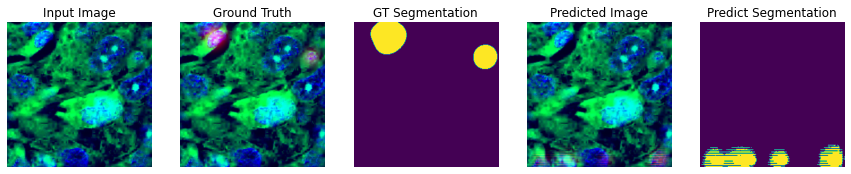

tf.Tensor(0.0, shape=(), dtype=float32)


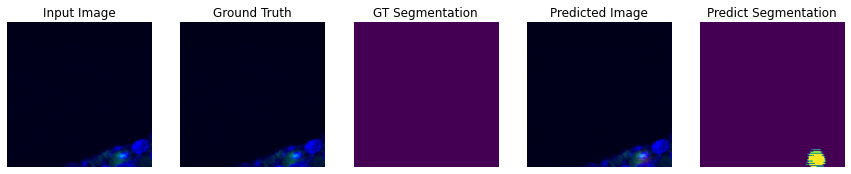

tf.Tensor(0.0, shape=(), dtype=float32)


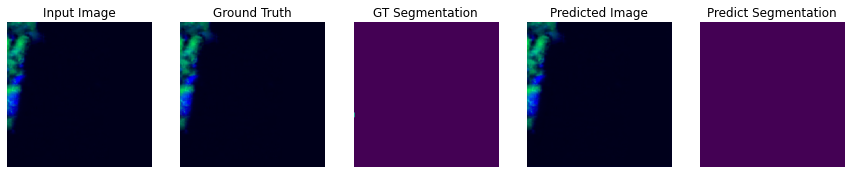

tf.Tensor(0.0, shape=(), dtype=float32)


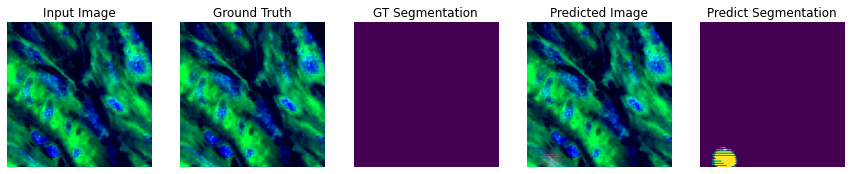

tf.Tensor(0.0, shape=(), dtype=float32)


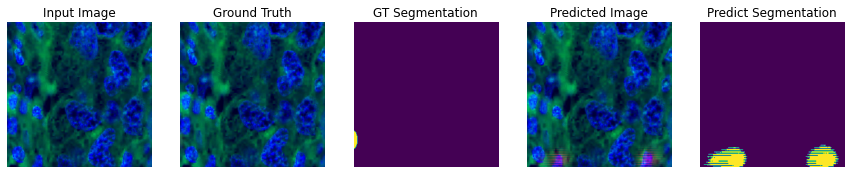

In [81]:
for example_input, example_target, example_filename in train_dataset.take(5):
    generate_images(generator, example_input, example_target)

In [82]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

In [83]:
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 128, 128, 64) 6144        concatenate_5[0][0]        

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [84]:
EPOCHS = 50

In [85]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [86]:
disc_loss_1=[]
gen_total_loss_1=[]
gen_l1_loss_1=[]
gen_gan_loss_1=[]
psnr=[]
ssim=[]

In [87]:
@tf.function
def train_step(input_image, target, filename, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    ps=tf.reduce_mean(tf.image.psnr(gen_output,target, max_val=1.0))
    #tf.print(ps)
    #psnr.append(ps)
    ss=tf.reduce_mean(tf.image.ssim(gen_output,target, 1.0))
    #ssim.append(ss)
    #tf.print(ss)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss,iou_val = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    tf.summary.scalar('ssim', ss, step=epoch)
    tf.summary.scalar('psnr', ps, step=epoch)
    tf.summary.scalar('1-iou',iou_val,step=epoch)
    #print("gen_l1_loss")
    #tf.print(gen_l1_loss, output_stream=sys.stderr)
    #print("gen_gan_loss")
    #tf.print(ss, output_stream=sys.stderr)
    #tf.print(gen_gan_loss, output_stream=sys.stderr)
    #print("disc_loss")
    #tf.print(disc_loss, output_stream=sys.stderr)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,disc_loss,ps,ss

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [88]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)
        
        # Update test dataset iteration
        for example_input, example_target, example_filename in test_ds.take(15):
            imgs, titles = generate_images(generator, example_input, example_target)
            # If you want to use filenames, you can do something like:
            # print("Example filename:", example_filename.numpy().decode('utf-8'))
        
        print("Epoch: ", epoch)
        
        # Train
        for n, (input_image, target, filename) in enumerate(train_ds):
            print('.', end='')
            
            # Update train_step call
            # If train_step doesn't use filename, you can pass it as None or modify train_step
            train_step(input_image, target, filename, epoch)
        
        # saving (checkpoint) the model every epoch
        manager.save()
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

In [89]:
checkpoint_dir

'./training_checkpoints/Sep21_Same_Dataset_Balanced/Dataset1_Sep21'

In [90]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))
#generator.load_weights(path_gen)
#discriminator.load_weights(path_dis)

tf.Tensor(0.0, shape=(), dtype=float32)


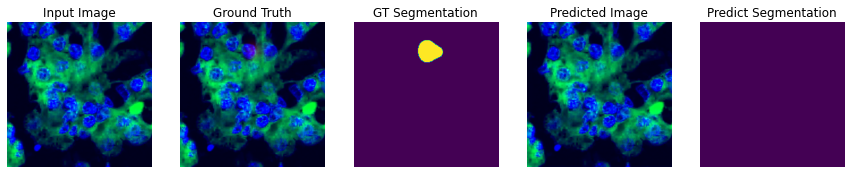

tf.Tensor(0.0, shape=(), dtype=float32)


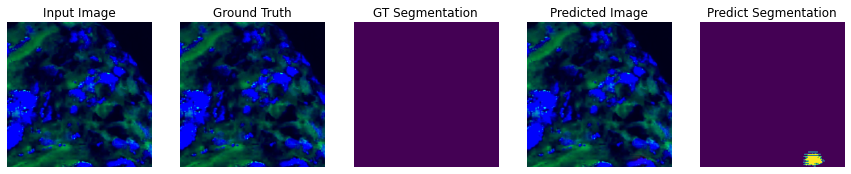

tf.Tensor(0.37350392, shape=(), dtype=float32)


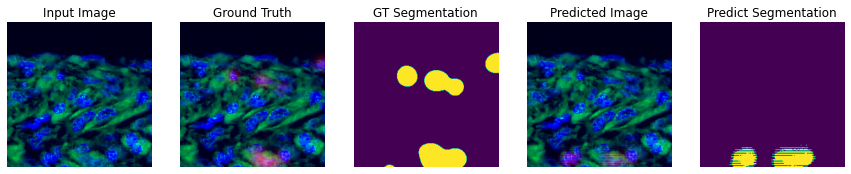

tf.Tensor(0.0, shape=(), dtype=float32)


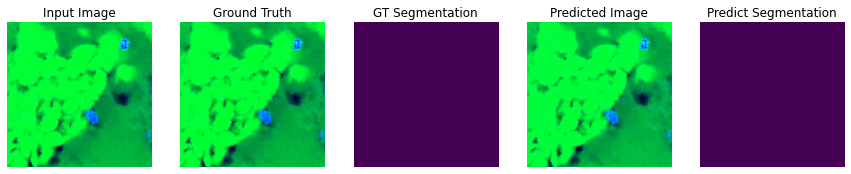

tf.Tensor(0.0, shape=(), dtype=float32)


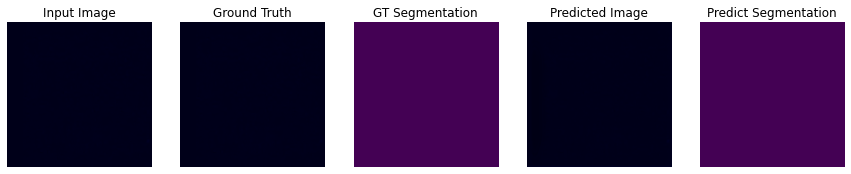

tf.Tensor(0.0, shape=(), dtype=float32)


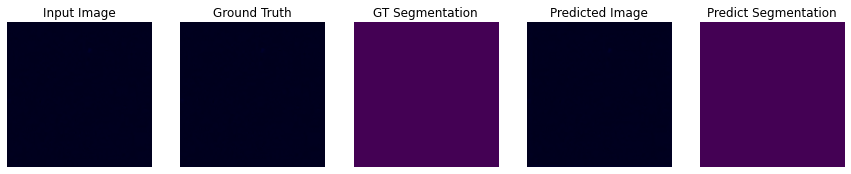

tf.Tensor(0.0, shape=(), dtype=float32)


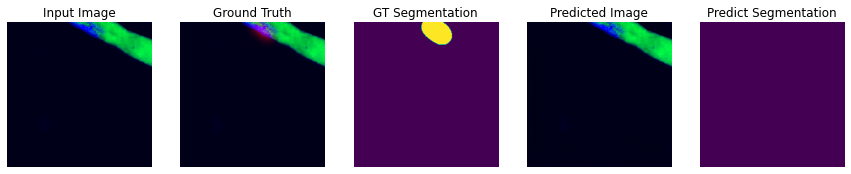

tf.Tensor(0.0, shape=(), dtype=float32)


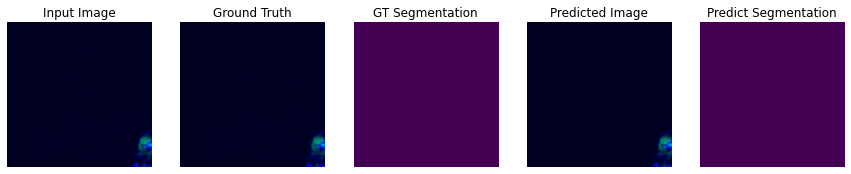

tf.Tensor(0.32910913, shape=(), dtype=float32)


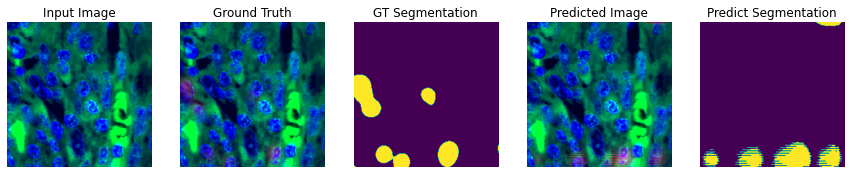

tf.Tensor(0.35544574, shape=(), dtype=float32)


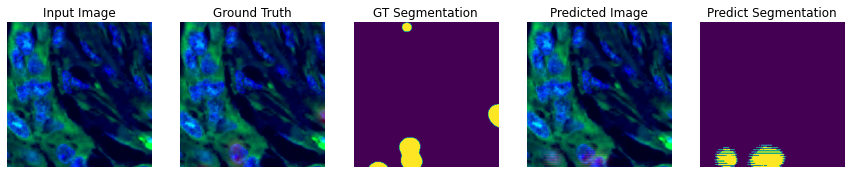

In [91]:
for example_input, example_target, filename in train_dataset.take(10):
            generate_images(generator, example_input, example_target)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [92]:
#docs_infra: no_execute
#!kill 1787
%load_ext tensorboard
%tensorboard --logdir {log_dir}  
#%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 351010), started 1 day, 4:22:23 ago. (Use '!kill 351010' to kill it.)

Now run the training loop:

tf.Tensor(0.0058379956, shape=(), dtype=float32)


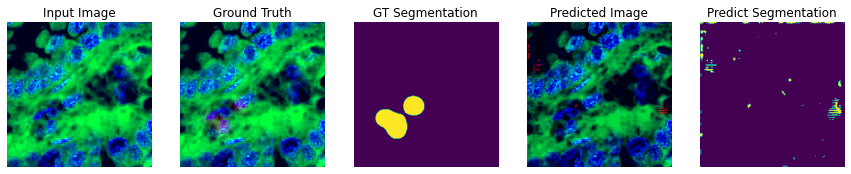

tf.Tensor(0.09042102, shape=(), dtype=float32)


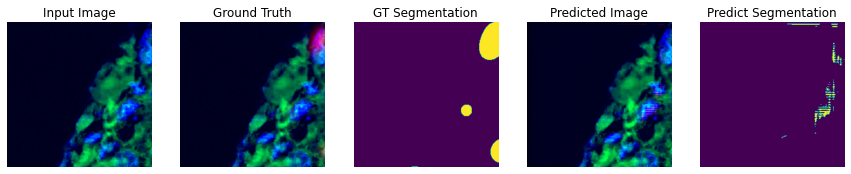

tf.Tensor(0.0, shape=(), dtype=float32)


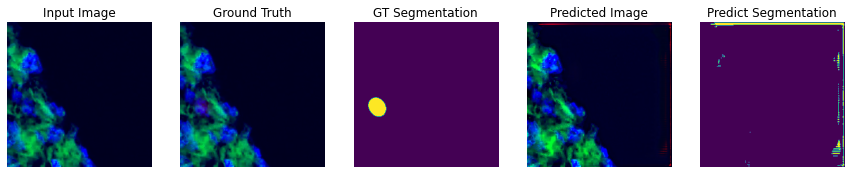

tf.Tensor(0.004406123, shape=(), dtype=float32)


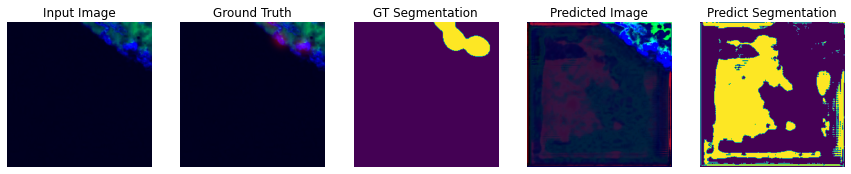

tf.Tensor(0.0063377093, shape=(), dtype=float32)


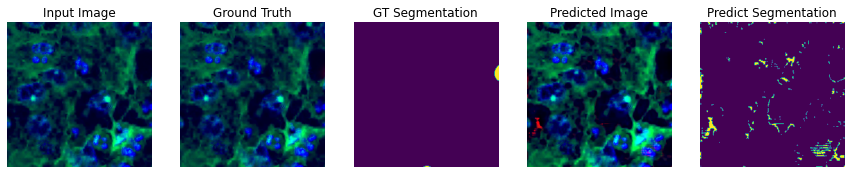

tf.Tensor(0.0, shape=(), dtype=float32)


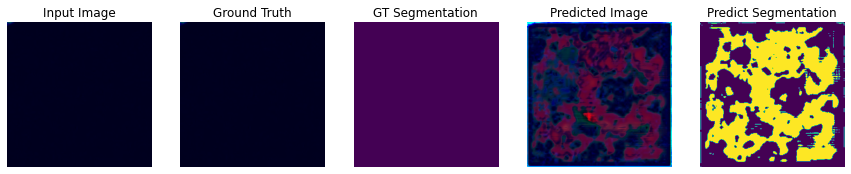

tf.Tensor(0.0010427529, shape=(), dtype=float32)


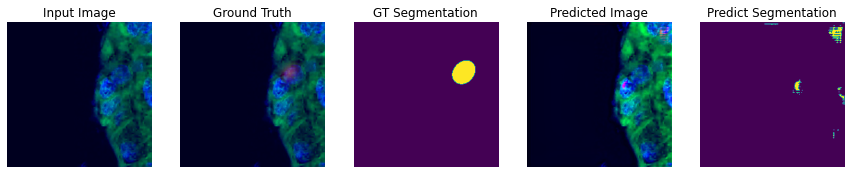

tf.Tensor(0.0, shape=(), dtype=float32)


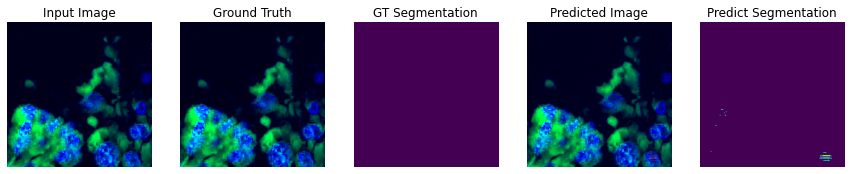

tf.Tensor(0.0, shape=(), dtype=float32)


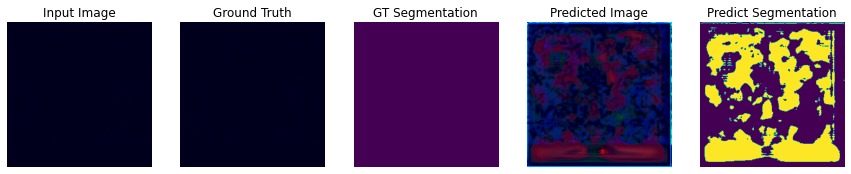

tf.Tensor(0.0007972892, shape=(), dtype=float32)


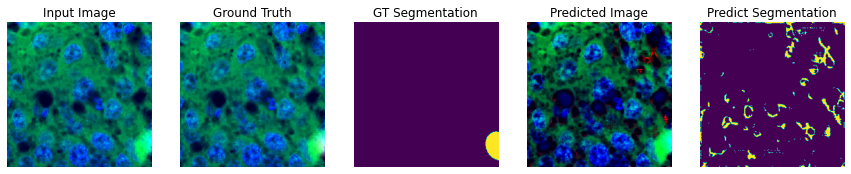

tf.Tensor(0.0, shape=(), dtype=float32)


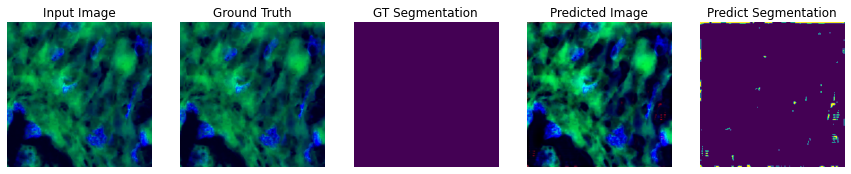

tf.Tensor(0.0, shape=(), dtype=float32)


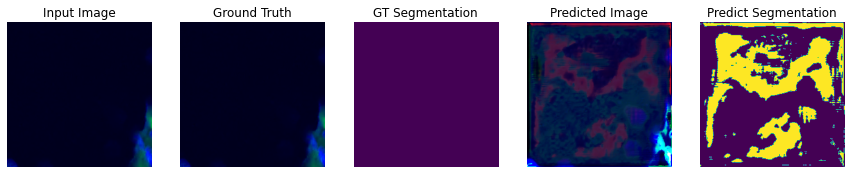

tf.Tensor(0.0, shape=(), dtype=float32)


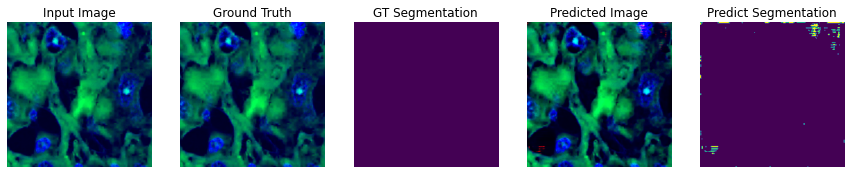

tf.Tensor(0.0, shape=(), dtype=float32)


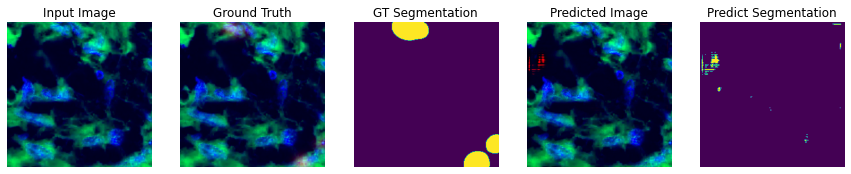

tf.Tensor(0.0, shape=(), dtype=float32)


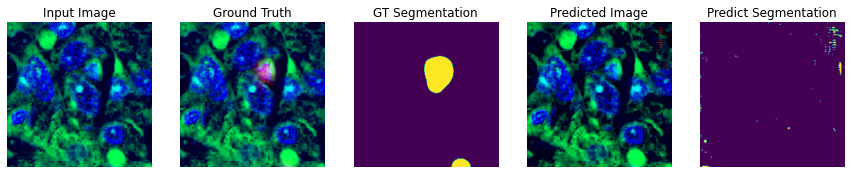

Epoch:  49
.........................................................................................................................................................................................................................................................................................................................................................................................Time taken for epoch 50 is 642.03 sec



In [93]:
fit(train_dataset, int(EPOCHS), valid_dataset)

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## CSV files to get shuffled patch indices (Running once is sufficient)

In [96]:
lst_sort=[]
images = sorted(glob(os.path.join(path, "Images/*")))
for x,y in zip(train_x,images):
    lst_sort.append([x.split("/")[-1],y.split("/")[-1]])

import pandas as pd
df_lst=pd.DataFrame(lst_sort)

# Get shuffled patch indices
df_lst.to_csv("/home/saab/Desktop/file_paths_Sep19_2024.csv")

In [97]:
lst_sort2=[]
for x in(test_x):
    lst_sort2.append([x.split("/")[-1]])
for x in(valid_x):
    lst_sort2.append([x.split("/")[-1]])
df_lst=pd.DataFrame(lst_sort2)
df_lst.to_csv("/home/saab/Desktop/file_paths_test_Sep19_2024.csv")

# Asking paths

In [98]:
p_train = filedialog.askdirectory(title='path for train_results')
p_test = filedialog.askdirectory(title='path for test_results')

In [99]:
p_train

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Train'

# Training dataset inference

In [100]:
def save_images(dataset, base_path):
    i=0
    for x, y, filenames in dataset:
        for a, b, fname in zip(x, y, filenames):
            v = generator(np.expand_dims(a, axis=0))
            img1 = v[0] * 0.5 + 0.5
            img2 = b * 0.5 + 0.5
            img3 = a * 0.5 + 0.5
            
            base_name = os.path.splitext(fname.numpy().decode('utf-8'))[0]
            
            plt.imsave(os.path.join(base_path, "pred", f"{base_name}_pred.png"), img1.numpy())
            plt.imsave(os.path.join(base_path, "gt", f"{base_name}_gt.png"), img2.numpy())
            plt.imsave(os.path.join(base_path, "img", f"{base_name}_input.png"), img3.numpy())
            print(base_name, end=" ")

# Save train images
save_images(train_dataset, p_train)

008128 002884 008765 003670 016221 020112 009046 003938 012659 004935 017080 012315 005659 006654 016682 000651 010606 012912 011790 018255 012988 001406 007172 018832 019407 005840 000463 004230 020083 012057 013674 018933 002855 002403 001736 009155 016321 003891 014760 018604 007243 013030 009383 010650 003630 000395 013483 003986 009568 005109 010766 011055 012676 017845 016242 013819 000631 019671 001090 000655 002625 014222 016211 004542 016885 005300 015853 004834 002024 002989 015574 017491 004155 001405 011162 007573 004663 004744 014210 018447 019228 011447 000272 015363 005625 006729 011718 014134 012428 004993 020464 008122 018823 005164 006175 016787 010566 009205 000803 001774 004674 018337 016405 015730 002057 010247 019970 012194 008087 002952 006719 014935 008571 004725 000539 007177 008894 019330 011364 001747 016212 004641 020564 004056 016350 004520 000384 003625 007352 003139 015789 012831 001645 016128 017786 000473 002949 005195 011176 009119 000597 006066 009130

# Testing dataset inference

In [101]:

def save_images(dataset1, base_path):
    for x, y, filenames in dataset1:
        for a, b, fname in zip(x, y, filenames):
            v = generator(np.expand_dims(a, axis=0))
            img1 = v[0] * 0.5 + 0.5
            img2 = b * 0.5 + 0.5
            img3 = a * 0.5 + 0.5
            
            base_name = os.path.splitext(fname.numpy().decode('utf-8'))[0]
            
            plt.imsave(os.path.join(base_path, "pred", f"{base_name}_pred.png"), img1.numpy())
            plt.imsave(os.path.join(base_path, "gt", f"{base_name}_gt.png"), img2.numpy())
            plt.imsave(os.path.join(base_path, "img", f"{base_name}_input.png"), img3.numpy())
            print(base_name, end=" ")
            
# Save test and validation images
save_images(test_dataset, p_test)
save_images(valid_dataset, p_test)

019143 009881 006542 013594 013852 001514 012930 017359 003917 018410 017709 014253 013799 017812 012931 013299 014015 005029 006842 019265 014426 001039 012518 000549 005558 011714 010391 004914 015865 020418 018579 007974 007817 013589 019334 013739 019924 018575 006689 011402 013651 015357 019728 002562 010132 013322 014763 010701 000676 014869 001295 000889 007893 001507 009984 017182 005483 016970 016659 011750 004163 004011 004499 009630 004350 008346 016365 012517 017548 013158 011177 006885 001696 017008 017741 000887 012498 008514 012909 008586 015546 001860 006321 016277 013345 016208 013174 005000 013304 007670 008865 001901 012418 019877 005086 005250 013145 002027 009121 012818 015937 020831 020135 020448 007586 016418 018206 012443 003957 012813 012040 001527 011684 018273 003501 004369 015948 011946 007262 013748 017827 000565 002767 014716 003327 019354 018423 002793 000202 014002 018638 015353 003308 001673 017166 007095 002289 012262 007905 016952 006041 012541 009772

In [101]:
plt.imshow(img1.numpy())

NameError: name 'img1' is not defined

In [ ]:
path_onco_sg=filedialog.askdirectory(title="onco_sg_images")
#date="13thOct"

files_onco_sg=[x for x in sorted(glob(path_onco_sg+"/*/*20x*.jpg"))]
st=set(([x.split("/")[len(x.split("/"))-2] for x in files_onco_sg]))
st=sorted(list(st))
len(st)

204

In [ ]:
st

['A006',
 'A008',
 'A012',
 'A015',
 'A016',
 'A017',
 'A021',
 'A025',
 'A027',
 'A028',
 'A033',
 'A037',
 'A062',
 'A063',
 'A066',
 'A068',
 'A071',
 'A072',
 'A073',
 'A074',
 'A100',
 'A101',
 'A102',
 'A103',
 'A104',
 'A109',
 'A110',
 'A111',
 'A112',
 'A114',
 'A117',
 'A120',
 'A122',
 'A124',
 'A126',
 'A130',
 'A131',
 'A134',
 'A136',
 'A138',
 'A139',
 'A143',
 'A144',
 'A146',
 'A147',
 'A148',
 'A149',
 'A150',
 'A152',
 'A153',
 'A155',
 'A156',
 'A157',
 'A158',
 'A159',
 'A162',
 'A163',
 'A165',
 'A167',
 'A168',
 'A169',
 'A177',
 'A182',
 'A183',
 'A184',
 'A185',
 'A186',
 'A187',
 'A188',
 'A190',
 'A191',
 'A192',
 'A193',
 'A194',
 'A195',
 'A196',
 'A197',
 'A198',
 'A199',
 'A200',
 'A201',
 'A202',
 'A204',
 'A205',
 'A206',
 'A207',
 'A208',
 'A209',
 'A210',
 'A211',
 'A212',
 'A213',
 'A214',
 'A215',
 'A216',
 'A217',
 'A218',
 'A219',
 'A220',
 'A221',
 'A222',
 'A228',
 'A229',
 'A230',
 'A232',
 'A233',
 'A234',
 'A239',
 'A240',
 'A241',
 'A243',
 

In [ ]:
path_predict_onco_sg=filedialog.askdirectory(title="predict_onco_sg_images")


In [ ]:
path_predict_onco_sg

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled'

In [ ]:

for x in st:
    os.makedirs(path_predict_onco_sg+"/"+x,exist_ok=True)
    y=sorted(glob(path_onco_sg+"/"+x+"/*20x*.jpg"))
    
    for z in y:
        fpath=path_predict_onco_sg+"/"+x+"/"+z.split("/")[-1]
        os.makedirs(fpath,exist_ok=True)
        spath=path_onco_sg+"/"+x+"/"+z.split("/")[-1]
        imgs_onco_sg=(sorted(glob(spath+"/*")))
        print(fpath)
        k=1
        for i in imgs_onco_sg:
            a=load_test(i,condtn=False)
            v=generator(np.expand_dims(a,axis=0))
            img=v[0]*0.5+0.5

            plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
            k=k+1
        

/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A006/A006, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A008/A008, paillary, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A012/A012, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A015/A015, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A016/A016, solid, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/

In [71]:
path_val=filedialog.askdirectory(title="validation_images")
#date="13thOct"

files_val=[x for x in sorted(glob(path_val+"/*"))]
st=set(([x.split("/")[-1] for x in files_val]))
st=sorted(list(st))
st

['000.png',
 '001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '007.png',
 '008.png',
 '009.png',
 '010.png',
 '011.png',
 '012.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '017.png',
 '018.png',
 '019.png',
 '020.png',
 '021.png',
 '022.png',
 '023.png',
 '024.png',
 '025.png',
 '026.png',
 '027.png',
 '028.png',
 '029.png',
 '030.png',
 '031.png',
 '032.png',
 '033.png',
 '034.png',
 '035.png',
 '036.png',
 '037.png',
 '038.png',
 '039.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '046.png',
 '047.png']

In [72]:
path_predict_val=filedialog.askdirectory(title="predict_validation_images")

In [76]:


for x in st:
    fpath=path_predict_val+"/"+x
    os.makedirs(fpath,exist_ok=True)
    y=sorted(glob(path_val+"/"+x+"/*"))
    #print(fpath)
    k=1
    print(len(y))
    for z in y:
        
        #print(z)
        
        a=load_valid(z,condtn=False)
        
    

        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5

        plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
           

        k=k+1    
        

420
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16


(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 240, 3)
184
16
441
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105

# Extra code

In [ ]:
#!pip install pandas
import pandas as pd



In [ ]:
images = sorted(glob(os.path.join(path, "images/*")))
masks = sorted(glob(os.path.join(path, "masks/*")))


In [ ]:
green = np.zeros([256,256,3],dtype=np.float32)
green[:]=(0,225,0)
green=green/127.5-1

In [ ]:
ind_ssim=[]
numbers=[]
for i in range(len(images)):
    print(i)
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    ss=tf.reduce_mean(tf.image.ssim(v,np.expand_dims(b,axis=0), 1.0))
    #gre=tf.reduce_mean(tf.math.sqrt(tf.abs(tf.math.square(green)-tf.math.square(v[0]))))
    img=v[0]*0.5+0.5
    plt.imshow(img.numpy())
    #tf.print(gre)
    
    ind_ssim.append((ss.numpy(),i))

    #img=np.asarray(v[0]*0.5+0.5,np.uint8)

In [ ]:
ind_ssim.sort()

In [ ]:
max(ind_ssim)

In [ ]:
ssim3=[]
for x in ind_ssim:
    ssim3.append(x[1])

In [ ]:

df_ssim_3=pd.DataFrame({"old_numbers":ssim3})

In [ ]:
df_ssim_3

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:

df_ssim_3=pd.read_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")
path_to_store=os.getcwd()+"/ans_cd3_new/"+date+"/"+mask+"/"
p1=os.path.join(path_to_store,"sorted")
p2=os.path.join(path_to_store,"unsorted")
p3=os.path.join(path_to_store,"sorted_gt")
p4=os.path.join(path_to_store,"unsorted_gt")
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)
os.makedirs(p3,exist_ok=True)
os.makedirs(p4,exist_ok=True)

In [ ]:
ssim3=df_ssim_3["old_numbers"].tolist()

In [ ]:
ssim3

In [ ]:
x=0
for i in (ssim3):
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    img2=b*0.5+0.5
    #plt.figure()
    #plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    
    plt.imsave(p1+"/"+f"{x:06d}"+".png",img.numpy())
    plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    plt.imsave(p3+"/"+f"{x:06d}"+".png",img2.numpy())
    plt.imsave(p4+"/"+f"{i:06d}"+".png",img2.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
b_test=glob(os.getcwd()+"/gt/*.png")
p099=os.getcwd()+"/new_test_dataset_results"+date
os.makedirs(p099,exist_ok=True)
x=0
for i in (b_test):
    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    #img2=b*0.5+0.5
    plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    plt.imsave(p099+"/"+f"{x:06d}"+".png",img.numpy())
    #plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:
os.getcwd()+"/old_nos_new_test"+date+".csv"

In [ ]:
new_test_path="/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles"
test_imgs_cptac=sorted(glob(new_test_path+"/*.png"))
len(test_imgs_cptac)

In [ ]:
x=0
test_predict=sorted(glob("/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/*"))
test_predict

In [ ]:
tpi=os.getcwd()+"/predict_hcc1_2"
os.makedirs(tpi,exist_ok=True)
for i in test_predict:

    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5

    plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())

    print(x,end=" ")
    x=x+1

In [ ]:
for tp in test_predict:
    x=0
    tpi=tp+"/predict"
    os.makedirs(tpi,exist_ok=True)
    test_imgs_cptac=sorted(glob(tp+"/small_tiles/*"))
    for i in (test_imgs_cptac):
        a=load(i,condtn=False)
        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5
    
        plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())
    
        print(x,end=" ")
        x=x+1
    print(" ")

In [ ]:
test_y

In [ ]:
p1=filedialog.askdirectory(title='path for unsorted_gt')
print(len(glob(p1+"/*.png")))
p2=filedialog.askdirectory(title='path for unsorted_pred')
print(len(glob(p2+"/*.png")))

In [ ]:
for x in test_y:
    os.remove(p1+"/"+x.split("/")[-1])
    os.remove(p2+"/"+x.split("/")[-1])

In [ ]:
print(len(glob(p1+"/*.png")))
print(len(glob(p2+"/*.png")))

In [57]:
path

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Preprocessed_Data/Serial_Slide/15thOct/Dataset1_Oversampled/Dataset'